In [1]:
data_dir = "."

In [2]:
import os

In [3]:
prefix = "pbmc_granulocyte_sorted_10k_"
for file in os.listdir(data_dir):
    if file.startswith(prefix):
        new_filename = file[len(prefix):]
        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [5]:
import muon as mu

In [7]:
mdata = mu.read_10x_h5('filtered_feature_bc_matrix.h5')


/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from filtered_feature_bc_matrix.h5


/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:915: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudat

Added peak annotation from atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: atac_fragments.tsv.gz


In [8]:
mdata.var_names_make_unique()
mdata

MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

In [9]:
from muon import atac as ac

In [10]:
atac = mdata.mod['atac']

In [11]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

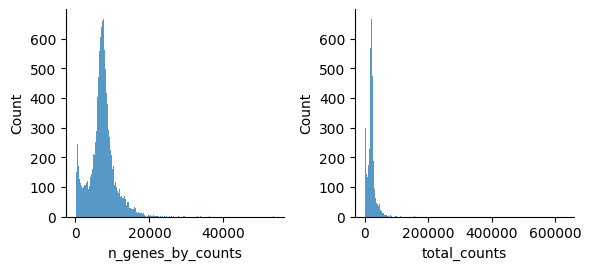

In [12]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

In [13]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)

In [16]:
print(f"Before: {atac.n_obs} cells")
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 80000))
print(f"(After total_counts: {atac.n_obs} cells)")
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 100) & (x <= 30000))
print(f"After: {atac.n_obs} cells")

Before: 11909 cells
(After total_counts: 11564 cells)
After: 11564 cells


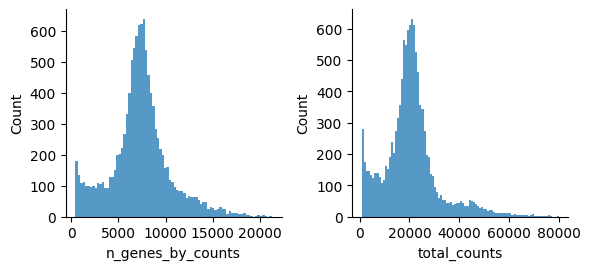

In [17]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

Fetching Regions...: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


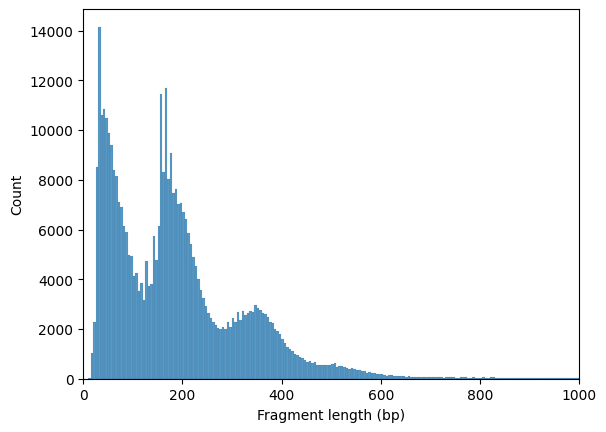

In [18]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [19]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:03<00:00, 276989.51it/s]


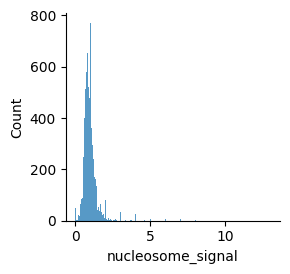

In [20]:
mu.pl.histogram(atac, "nucleosome_signal", linewidth=0)

In [21]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)

,Chromosome,Start,End,gene_id,gene_name
MIR1302-2HG,chr1,29553,30267,ENSG00000243485,MIR1302-2HG
FAM138A,chr1,36080,36081,ENSG00000237613,FAM138A
OR4F5,chr1,65418,69055,ENSG00000186092,OR4F5


In [22]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)

Fetching Regions...: 100%|██████████| 1000/1000 [00:13<00:00, 75.85it/s]
/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [23]:
tss

AnnData object with n_obs × n_vars = 11564 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

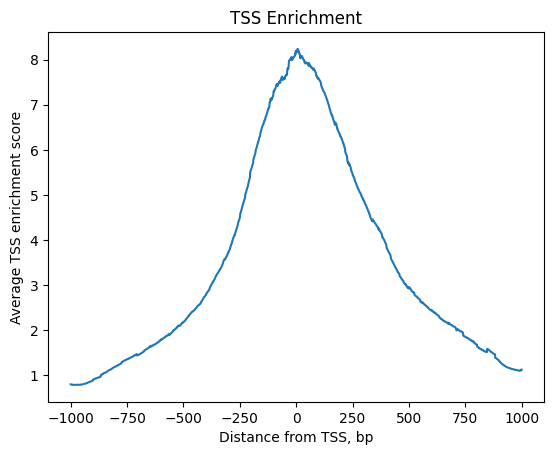

In [24]:
ac.pl.tss_enrichment(tss)

In [25]:
atac.layers["counts"] = atac.X.copy()
sc.pp.normalize_total(atac, target_sum=1e4)
sc.pp.log1p(atac)
atac.layers["lognorm"] = atac.X.copy()

In [26]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


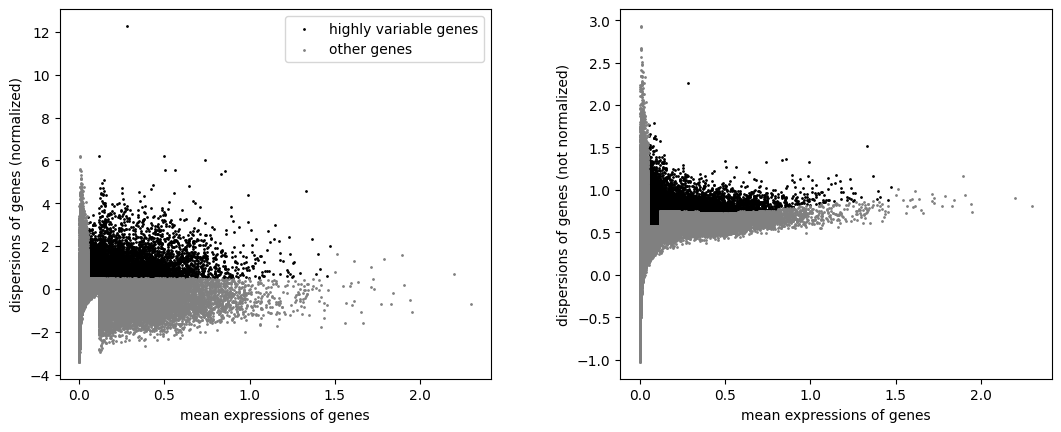

In [27]:
sc.pl.highly_variable_genes(atac)

In [28]:
np.sum(atac.var.highly_variable)

np.int64(11771)

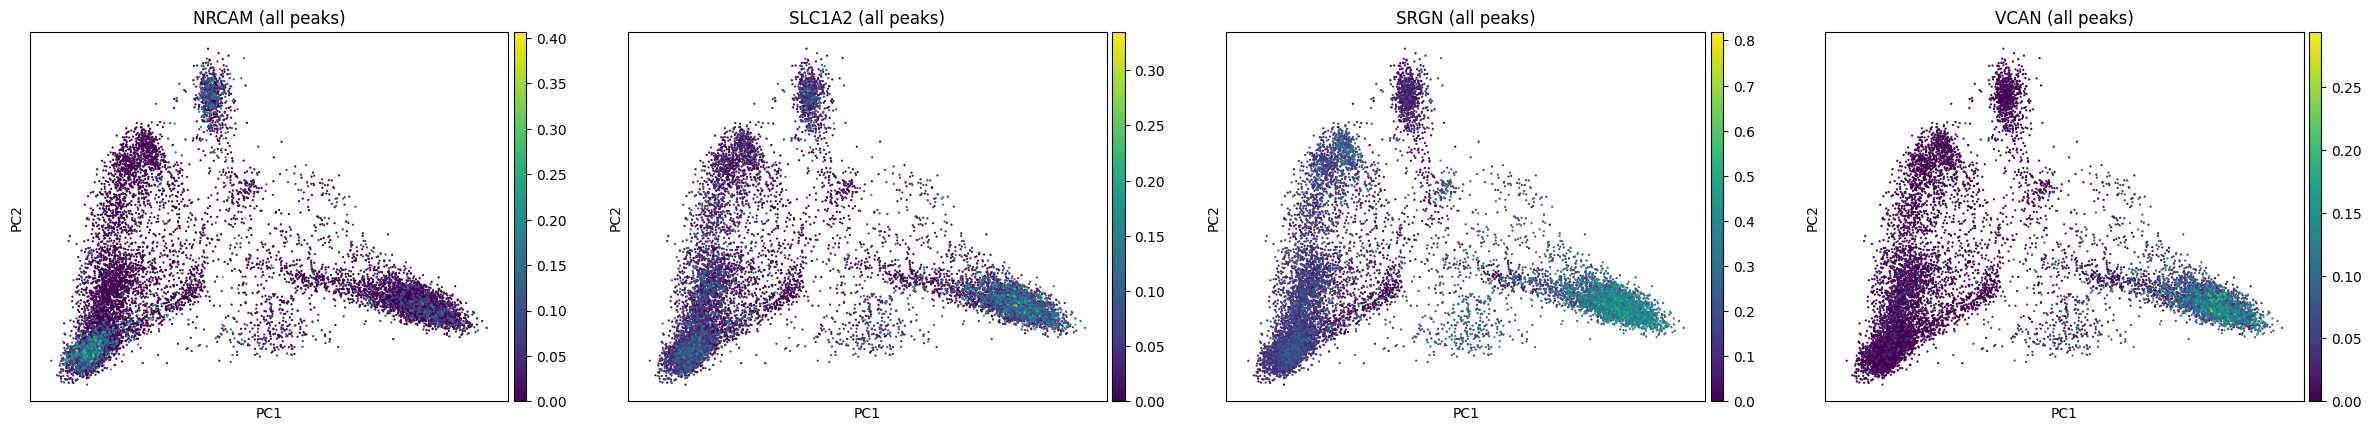

In [32]:
sc.pp.scale(atac, max_value=10)
sc.tl.pca(atac, svd_solver='arpack')
ac.pl.pca(atac, color=['NRCAM', 'SLC1A2', 'SRGN', 'VCAN'], layer='lognorm', func='mean')

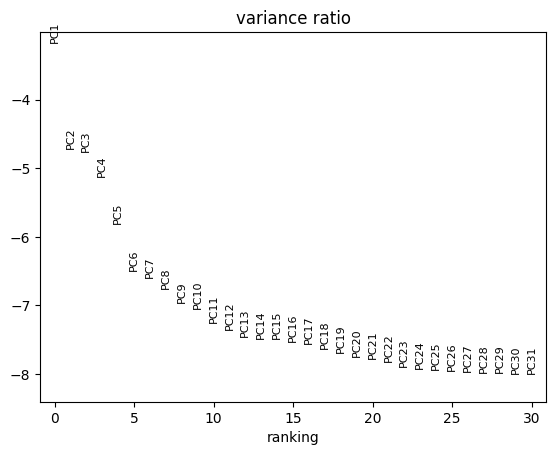

In [33]:
sc.pl.pca_variance_ratio(atac, log=True)

In [34]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=20)

In [35]:
sc.tl.leiden(atac, resolution=.5)

/var/folders/j0/6b9x3l9n5nzgmbj9pcz255xc0000gq/T/ipykernel_5436/937485634.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=.5)


In [36]:
sc.tl.umap(atac, spread=1., min_dist=.5, random_state=11)

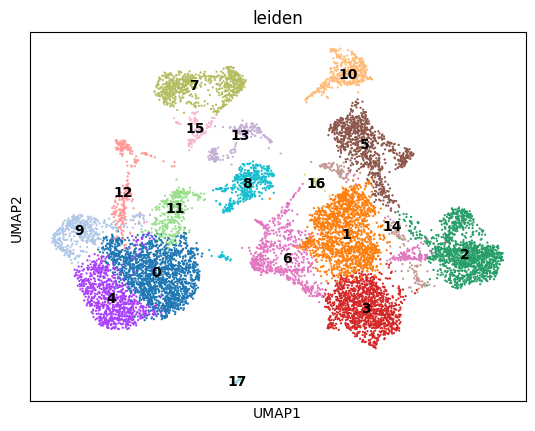

In [37]:
sc.pl.umap(atac, color="leiden", legend_loc="on data")

In [38]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/pfb2024/.local/lib

In [39]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names

In [40]:
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

,0_n,0_g,0_p,1_n,1_g,1_p,2_n,2_g,2_p,3_n,...,14_p,15_n,15_g,15_p,16_n,16_g,16_p,17_n,17_g,17_p
0,chr9:107480158-107492721,KLF4,0.0,chr14:22536559-22563070,"TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...",2.859959e-278,chr2:86783559-86792275,CD8A,9.319763e-315,chr14:99255246-99275454,...,2.108736e-49,chr22:41917087-41929835,TNFRSF13C,0.000002,chr16:88448143-88480965,ZFPM1,4.322022e-10,chr19:21593423-21595308,AC123912.2,1.085685e-07
1,chr11:61953652-61974246,"BEST1, FTH1",0.0,chr14:99255246-99275454,"BCL11B, AL109767.1",1.115128e-184,chr14:99255246-99275454,"BCL11B, AL109767.1",2.816836e-274,chr14:99223600-99254668,...,6.360651e-47,chr10:95290334-95291684,PDLIM1,0.000011,chr5:35850992-35860227,IL7R,7.201007e-08,chr14:75267507-75300328,"FOS, AL691403.1, AF111167.1, LINC01220",2.915830e-06
2,chr1:212604203-212626574,"FAM71A, ATF3, AL590648.2",0.0,chr10:8041366-8062418,"GATA3, GATA3-AS1, AL390294.1",1.035669e-169,chr11:66311352-66319301,"CD248, AP001107.3",4.967622e-261,chr14:99181080-99219442,...,2.782674e-46,chr10:48671056-48673240,AC068898.1,0.000014,chr22:39087900-39092994,APOBEC3H,1.269553e-07,chr3:128485776-128493826,"GATA2, GATA2-AS1",3.350269e-06
3,chr19:13824929-13854962,"ZSWIM4, AC020916.1",0.0,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",2.660963e-163,chr2:136122469-136138482,CXCR4,4.560115e-243,chr14:22536559-22563070,...,1.197180e-44,chr19:2679925-2682216,"GNG7, AC006538.3",0.000016,chr14:105856766-105860740,IGHM,9.403634e-07,chr21:44965117-44970844,"FAM207A, AP001505.1",5.249908e-06
4,chr7:106256272-106286624,"NAMPT, AC007032.1",0.0,chr14:99223600-99254668,"BCL11B, AL109767.1",4.128885e-151,chr12:10552886-10555668,LINC02446,1.831914e-212,chr7:142782798-142813716,...,1.411818e-40,chr2:25419179-25422554,"DTNB, AC104699.1",0.000018,chr5:178112840-178119590,N4BP3,1.103862e-06,chr17:82211956-82220400,"CCDC57, AC132872.2",6.219739e-06
5,chr9:134369462-134387253,RXRA,0.0,chr20:59157931-59168100,ZNF831,1.576783e-144,chr14:99181080-99219442,"BCL11B, AL162151.1",2.295427e-214,chr17:82125073-82129615,...,6.235724e-38,chr8:28338050-28340083,"PNOC, AC021678.2",0.000019,chr16:85609841-85617514,GSE1,1.203062e-06,chr17:40306445-40353516,"RARA, RARA-AS1, AC080112.4",6.291058e-06
6,chr3:72092464-72103763,LINC00877,0.0,chr14:91240967-91256390,"GPR68, AL135818.1",7.762323e-133,chr14:99223600-99254668,"BCL11B, AL109767.1",4.838562e-217,chr19:16363226-16378669,...,1.989619e-37,chr8:41622033-41623631,"GPAT4, AC009630.3",0.000019,chr7:38232007-38235173,TRGC2,1.229320e-06,chr19:1230013-1281741,"CIRBP, ATP5F1D, CBARP, MIDN, FAM174C, CIRBP-AS...",6.265509e-06
7,chr5:150385442-150415310,"CD74, TCOF1",0.0,chr5:35850992-35860227,IL7R,3.579326e-130,chr1:24500773-24509089,"RCAN3, RCAN3AS",3.096740e-193,chr17:40601555-40611036,...,4.045113e-35,chr15:70014517-70016964,TLE3,0.000030,chr20:63733192-63743479,"SLC2A4RG, ZGPAT, LIME1",1.277530e-06,chr19:858736-866420,CFD,7.266753e-06
8,chr2:47067863-47077814,"TTC7A, AC073283.1",0.0,chr10:33135632-33141841,IATPR,1.290152e-127,chr17:82125073-82129615,CCDC57,5.857589e-190,chr14:61319750-61346673,...,1.736956e-32,chr2:136206403-136208084,CXCR4,0.000039,chr19:16363226-16378669,"EPS15L1, AC020917.3",2.850295e-06,chr14:50303663-50304236,L2HGDH,8.756939e-06
9,chr22:38950570-38958424,APOBEC3A,0.0,chr6:37512323-37518673,LINC02520,2.420309e-124,chr7:142782798-142813716,"TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...",2.077558e-194,chr2:136122469-136138482,...,1.930469e-32,chr20:43681305-43682881,MYBL2,0.000047,chr1:2493438-2508142,"PLCH2, AL139246.4",3.035319e-06,chr10:133265906-133281093,"TUBGCP2, ADAM8",8.974810e-06


In [49]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin(["9"]))

ValueError: Value passed for key 'X_pca' is of incorrect shape. Values of obsm must match dimensions ('obs',) of parent. Value had shape (11564,) while it should have had (11138,).

In [42]:
new_cluster_names = {
    "0": "oligodendrocyte",
    "1": "oligodendrocyte",
    "3": "OPC",
    "7": "microglia",
    "2": "astrocyte",
    "8": "astrocyte",
    "4": "excitatory",
    "5": "inhibitory1",
    "6": "inhibitory2",
}

In [43]:
atac.obs['celltype'] = [new_cluster_names[cl] for cl in atac.obs.leiden.astype("str").values]
atac.obs.celltype = atac.obs.celltype.astype("category")

KeyError: '14'